# Twitter Sentiment Analysis

### Importing necessary Libraries

In [1]:
import re
import nltk
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import twitter_samples, stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to C:\Users\Sodiq Agba
[nltk_data]     ML\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sodiq Agba
[nltk_data]     ML\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Importing Dataset

In [3]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

In [4]:
positive_tweets[1], negative_tweets[1]

('@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
 "Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(")

In [5]:
len(positive_tweets), len(negative_tweets)

(5000, 5000)

### Dataframe

In [6]:
positive_df = pd.DataFrame({'Tweets': positive_tweets, 'Sentiment' : np.ones(len(positive_tweets))})
negative_df = pd.DataFrame({'Tweets': negative_tweets, 'Sentiment': np.zeros(len(positive_tweets))})

tweets_df = pd.concat([positive_df, negative_df], axis = 0).sample(n = 10000).reset_index(drop = True)

In [7]:
tweets_df.head()

,Tweets,Sentiment
0,.... My gosh ... I'm really bad at physics :(,0.0
1,@jan_iyer :( u didnt wish suriya anna....,0.0
2,vidcon :(((,0.0
3,@Atunci_CoV @QuetaAuthor :( rude,0.0
4,@fxnno_ i knew u would be sad :( were having a...,0.0


In [8]:
tweets_df['Sentiment'].value_counts(normalize = True)

0.0    0.5
1.0    0.5
Name: Sentiment, dtype: float64

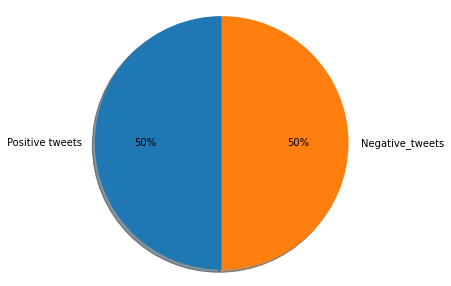

In [9]:
fig = plt.figure(figsize = (5,5))

labels = 'Positive tweets', 'Negative_tweets'

X = [len(positive_tweets), len(negative_tweets)]

plt.pie(x = X , labels = labels, startangle=90, shadow = True, autopct='%1.0f%%')

plt.axis('equal')

plt.show()

# Data Preprocessing Functions

### Tweet cleaning

In [10]:
def tweet_cleaning(tweet):
    ### Removing Hyper links
    new_tweet = re.sub(r'https?://.[.]\w{2}[/]\w+', '', tweet)
    ### Removing @ sign
    new_tweet = re.sub(r'@', '', new_tweet)
    ### Removing Hash tag
    new_tweet = re.sub(r'#', '', new_tweet)
    return new_tweet

### Tokenization

In [11]:
def tweet_tokenizer(tweet):
    tokenizer = TweetTokenizer(preserve_case= False, reduce_len=False, strip_handles=False)
    return tokenizer.tokenize(tweet)

### Stemming

In [12]:
def tweet_stemmer(word_list):
    stemmer = PorterStemmer()
    stemmed_word = []
    for word in word_list:
        stemmed_word.append(stemmer.stem(word))
    return stemmed_word

### Removing stopwords and Punctuation

In [13]:
def token_clean(token):
    punctuations = string.punctuation
    stop_words = stopwords.words('english')
    new_token = [word for word in token if word not in punctuations if word not in stop_words]
    return new_token

### Single Clean Function

In [14]:
def tweet_to_token(tweet):
    cleaned_tweet = tweet_cleaning(tweet)
    token = tweet_tokenizer(cleaned_tweet)
    token_stem = tweet_stemmer(token)
    final_token = token_clean(token_stem)
    
    return final_token

### Bag of words

In [15]:
def Bag_of_words(tweet_token):
    BOW = []
    for token in tweet_token:
        for word in token:
            BOW.append(word)
    return BOW

### Weight dictionary

In [16]:
def word_weight_dict(BOW, bow):
    word_dict = {}
    for x in BOW:
        word_dict[x] = 0
        for y in bow:
            if x == y:
                word_dict[x] += 1
            else:
                word_dict[x] += 0
    return word_dict

## Applying Cleaning Functions

In [17]:
tweets_df['Token'] = tweets_df['Tweets'].apply(tweet_to_token)

In [18]:
bow = Bag_of_words(tweets_df['Token'])
bow = pd.Series(bow).unique()

### Words dictionary

In [19]:
positive_bow = Bag_of_words(tweets_df['Token'][tweets_df['Sentiment'].eq(1)])#Positive sentiment words
negative_bow = Bag_of_words(tweets_df['Token'][tweets_df['Sentiment'].eq(0)])#Negative sentiments words

In [20]:
positive_dict = word_weight_dict(bow, positive_bow)
negative_dict = word_weight_dict(bow, negative_bow)

### Words Probability

In [32]:
def dict_sum(dict_):
    sum_ = 0
    for x in dict_:
        sum_ += dict_.get(x)
    return sum_

In [33]:
def word_prob(freq_dict):
    N = dict_sum(freq_dict)
    V = len(freq_dict)
    prob_dict = {}
    for word in freq_dict:
        val = freq_dict.get(word)
        prob = (val + 1)/ (N + V)
        prob_dict[word] = prob
    return prob_dict

In [34]:
positive_prob = word_prob(positive_dict)
negative_prob = word_prob(negative_dict)

In [46]:
def tweet_prob(tweet_token):
    weight = np.log(len(positive_tweets)/len(negative_tweets))
    for word in tweet_token:
        pos_prob = positive_prob.get(word,0)
        neg_prob = negative_prob.get(word,0)
        weight += np.log(pos_prob/neg_prob)
    return weight

In [48]:
tweets_df['Tweet_Probability'] = tweets_df['Token'].apply(tweet_prob)
tweets_df['Pred_sentiment'] = tweets_df['Tweet_Probability'].apply(lambda x: 0 if x < 0 else 1)

In [55]:
tweets_df.head()

,Tweets,Sentiment,Token,Tweet_Probability,Pred_sentiment
0,.... My gosh ... I'm really bad at physics :(,0.0,"[..., gosh, ..., i'm, realli, bad, physic, :(]",-13.126264,0
1,@jan_iyer :( u didnt wish suriya anna....,0.0,"[jan_iy, :(, u, didnt, wish, suriya, anna, ...]",-14.201754,0
2,vidcon :(((,0.0,"[vidcon, :(]",-8.845285,0
3,@Atunci_CoV @QuetaAuthor :( rude,0.0,"[atunci_cov, quetaauthor, :(, rude]",-10.414659,0
4,@fxnno_ i knew u would be sad :( were having a...,0.0,"[fxnno, knew, u, would, sad, :(, funer, wa, go...",-14.519977,0


In [57]:
print(classification_report(tweets_df['Sentiment'], tweets_df['Pred_sentiment']))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5000
         1.0       1.00      1.00      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [64]:
actual = tweets_df['Sentiment']
pred = tweets_df['Pred_sentiment']
print(f'Model Accuracy : {accuracy_score(actual,pred)}')
print(f'Model F1 score : {f1_score(actual,pred)}')
print(f'Model Precision : {precision_score(actual,pred)}')
print(f'Model Recall : {recall_score(actual,pred)}')

Model Accuracy : 0.9994
Model F1 score : 0.9993997599039617
Model Precision : 0.9997998398718975
Model Recall : 0.999


In [66]:
pd.DataFrame(confusion_matrix(actual,pred), columns = ['Positive','Negative'], index= ['Positive','Negative'])

,Positive,Negative
Positive,4999,1
Negative,5,4995
